In [16]:
"""
Replace with an E.164 phone number
or iMessage handle, eg
RECIPIENT_ID = '+13031234567'
RECIPIENT_ID = 'foo@bar.com'
"""
RECIPIENT_ID = 'CHANGEME'

In [2]:
assert RECIPIENT_ID != 'CHANGEME'

In [3]:
import os
import sqlite3

import emoji
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
from itertools import chain

from matplotlib.ticker import MaxNLocator
from nltk import Text
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize
from nltk.tokenize.casual import TweetTokenizer
from tabulate import tabulate
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

%matplotlib notebook

In [4]:
CHAT_DB_PATH = os.path.expanduser('~/Library/Messages/chat.db')
def imessage_chat(recipient_id, from_me,
                  chat_db_path=CHAT_DB_PATH):
    sql = """
    SELECT
        text
    FROM
        message
    INNER JOIN
        handle
    ON
        message.handle_id = handle.rowid
    WHERE
        handle.id = ?
    AND
        is_from_me = ?
    """
    with sqlite3.connect(chat_db_path) as conn:
        cursor = conn.cursor()
        return [message[0] for message in \
                cursor.execute(sql, (recipient_id, from_me))]

In [5]:
def normalize_messages(messages):
    tokenizer = TweetTokenizer(preserve_case=False)
    normalized_messages = []
    for message in messages:
        try:
            tokens = tokenizer.tokenize(message)
            text = [word.lower() for word in Text(tokens)]
            if text:
                normalized_messages.append(text)
        except TypeError:
            pass
    return normalized_messages

def stem(messages):
    stemmer = PorterStemmer()
    return [[stemmer.stem(word) for word in message] \
            for message in messages]

STOPWORDS = stopwords.words('english')
def filter_stopwords(messages, stopword_corpus=STOPWORDS):
    return [[word for word in message \
             if word not in stopword_corpus] \
            for message in messages]

def filter_english(messages):
    return [[word for word in message \
             if wordnet.synsets(word)] \
            for message in messages]

def filter_alpha(messages):
    return [[word for word in message if word.isalpha()] \
            for message in messages]

def sentences(messages):
    sentences = []
    for message in messages:
        try:
            sentences.append(sent_tokenize(message))
        except TypeError:
            pass
    return sentences

def frequency(items):
    counts = defaultdict(int)
    for item in items:
        counts[item] += 1
    return sorted(counts.items(), key=lambda x: x[1], reverse=True)

def vocab(messages):
    return frequency(chain.from_iterable(
        filter_alpha(filter_stopwords(messages))))

def emojis(messages):
    return frequency(char for char in \
                     chain.from_iterable(messages) \
                     if char in emoji.UNICODE_EMOJI)

def sentiment(messages):
    analyzer = SentimentIntensityAnalyzer()
    negative = []
    neutral = []
    positive = []
    compound = []
    for sentence in \
            chain.from_iterable(sentences(messages)):
        res = analyzer.polarity_scores(sentence)
        negative.append(res['neg'])
        neutral.append(res['neu'])
        positive.append(res['pos'])
        compound.append(res['compound'])

    return pd.DataFrame({
        'negative':negative,
        'neutral':neutral,
        'positive':positive,
        'compound':compound
    })

def emoji_table(messages):
    return pd.DataFrame(emojis(messages),
                        columns=['Emoji',
                                 'Frequency'])
def vocab_table(messages):
    df = pd.DataFrame(vocab(messages),
                      columns=['Word',
                               'Frequency'])
    df.set_index('Word', inplace=True)
    return df

def word_count_table(messages):
    return pd.DataFrame([len(x) for x in messages],
                        columns=['Word Count'])

def full_title(title, title_suffix):
    if title_suffix:
        return "{0} ({1})".format(title, title_suffix)
    return title

def emoji_plot(emojis, title_suffix=None, ax=None,
               figsize=None):
    title = 'Most Frequently Used Emojis'
    ax = emojis.plot(kind='bar',
                     title=full_title(title, title_suffix),
                     ax=ax,
                     figsize=figsize)
    ax.set_xlabel('Emoji Index')
    ax.set_ylabel('Emoji Frequency')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
def vocab_plot(vocab, title_suffix=None, ax=None,
               figsize=None):
    title = 'Most Frequently Used Words'
    ax = vocab.plot(kind='bar',
                    title=full_title(title, title_suffix),
                    ax=ax,
                    figsize=figsize)
    ax.set_xlabel('Word')
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    ax.set_ylabel('Word Usage Frequency')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
def sentiment_plot(sentiment, title_suffix=None, ax=None,
                   figsize=None):
    title = 'Distribution of Message Sentiments'
    ax = sentiment.plot(kind='density',
                        title=full_title(title, title_suffix),
                        ax=ax,
                        figsize=figsize)
    ax.set_xlim([-1, 1])
    
def word_count_plot(word_counts, title_suffix=None, ax=None,
                    figsize=None):
    title = 'Distribution of Word Counts'
    ax = word_counts.plot(kind='density',
                          title=full_title(title, title_suffix),
                          ax=ax,
                          figsize=figsize)
    ax.set_xlabel('Words per Message')
    
def word_cloud(messages, width=12, height=12,
               max_font_size=40):
    text = " ".join(chain.from_iterable(filter_stopwords(messages)))
    cloud = WordCloud(max_font_size=max_font_size).generate(text)
    plt.figure(figsize=(width, height))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    
def comparison_plot(plot_func, from_data, to_data,
                    width=12, height=6):
    if from_data.empty and to_data.empty:
        return
    
    fig_size = (width, height)
    if from_data.empty:
        plot_func(to_data, title_suffix='To Me',
                  figsize=fig_size)
        return
    if to_data.empty:
        plot_func(from_data, title_suffix='From Me',
                  figsize=fig_size)
        return

    fig, ax = plt.subplots(1,2, figsize=fig_size)
    plot_func(from_data, title_suffix='From Me', ax=ax[0])
    plot_func(to_data, title_suffix='To Me', ax=ax[1])

def avg_message_words(messages):
    return np.mean(np.array([len(x) for x in messages]))

def avg_message_chars(messages):
    char_counts = [sum([len(x) for x in message]) for \
                   message in messages]
    return np.mean(np.array(char_counts))

def longest_message(messages):
    if not messages:
        return 0
    return max(len(x) for x in messages)

def pct_sentiment(sentiment, comp):
    compound = sentiment['compound']
    return 100*compound[comp(compound)].count()/ \
           len(compound)

class Metric(object):
    
    def __init__(self, name, calc,
                 format_str=f"{0}"):
        self.name = name
        self.calc = calc
        self.format_str = format_str
        
    def compute(self, messages, sentiment):
        return self.calc(messages, sentiment)
    
    def formatted(self, messages, sentiment):
        val = self.compute(messages, sentiment)
        return self.format_str.format(val)

METRICS = [
    Metric('Message Count',
           lambda messages, sentiment: len(messages),
           "{:,}"),
    Metric('Word Count',
           lambda messages, sentiment: \
               sum(len(x) for x in messages),
           "{:,}"),
    Metric('Avg Message Word Count',
           lambda messages, sentiment: \
               avg_message_words(messages),
           "{0:.2f}"),
    Metric('Avg Message Word Count (w/o Stop Words)',
           lambda messages, sentiment: \
               avg_message_words(filter_stopwords(messages)),
           "{0:.2f}"),
    Metric('Avg Message Character Count',
           lambda messages, sentiment: \
               avg_message_chars(messages),
           "{0:.2f}"),
    Metric('Avg Message Character Count (w/o Stop Words)',
           lambda messages, sentiment: \
               avg_message_chars(filter_stopwords(messages)),
           "{0:.2f}"),
    Metric('Longest Message',
           lambda messages, sentiment: \
               longest_message(messages),
           "{:,}"),
    Metric('Distinct Words',
           lambda messages, sentiment: len(vocab(messages)),
           "{:,}"),
    Metric('Distinct Stems',
           lambda messages, sentiment: \
               len(vocab(stem(messages))),
           "{:,}"),
    Metric('Distinct English Words',
           lambda messages, sentiment: \
               len(vocab(filter_english(messages))),
           "{:,}"),
    Metric('Distinct Emojis',
           lambda messages, sentiment: len(emojis(messages)),
           "{:,}"),
    Metric('Emoji Count',
           lambda messages, sentiment: \
               sum(x[1] for x in emojis(messages)),
           "{:,}"),
    Metric('Pct Negative Sentiment',
           lambda messages, sentiment: \
               pct_sentiment(sentiment, lambda x: x < -.5),
           "{0:.0f}%"),
    Metric('Pct Positive Sentiment',
           lambda messages, sentiment: \
               pct_sentiment(sentiment, lambda x: x > .5),
           "{0:.0f}%")
]
        
def summary_table(messages, sentiment, metrics=METRICS):
    table = [[metric.name,
              metric.formatted(messages, sentiment)] \
             for metric in metrics]
    print(tabulate(table, headers=['Metric', 'Value'],
                   tablefmt='orgtbl'))
    
def emoji_summary(emojis, title_suffix=None):
    emojis = emojis['Emoji'].values.tolist()
    rank = [x+1 for x in range(len(emojis))]
    table = [x for x in zip(rank, emojis)]
    title = 'Emoji Rank'
    headers = [full_title(title, title_suffix), 'Emoji']
    print(tabulate(table, headers=headers))

def summary_comparison(from_messages, from_sentiment,
                       to_messages, to_sentiment,
                       metrics=METRICS):
    table = [[metric.name,
              metric.formatted(from_messages, from_sentiment),
              metric.formatted(to_messages, to_sentiment)] \
             for metric in metrics]
    print(tabulate(table, headers=['Metric', 'From Me', 'To Me'],
                   tablefmt='orgtbl'))
    
def emoji_comparison(from_emojis, to_emojis):
    if from_emojis.empty and to_emojis.empty:
        return
    if from_emojis.empty:
        emoji_summary(to_emojis, title_suffix='To Me')
        return
    if to_emojis.empty:
        emoji_summary(from_emojis, title_suffix='From Me')
        return

    from_emojis = from_emojis['Emoji'].values.tolist()
    to_emojis = to_emojis['Emoji'].values.tolist()
    rank = [x+1 for x in range(len(to_emojis))]
    table = [x for x in zip(rank, from_emojis, to_emojis)]
    print(tabulate(table,
                   headers=['Emoji Rank', 'From Me', 'To Me']))

In [6]:
"""
You can filter messages and pull from sources
other than iMessage by redefining the from_messages
and to_messages variables; subsequent analysis
functions expect that both variables are lists of strings.
"""

from_messages = imessage_chat(RECIPIENT_ID, True)
to_messages = imessage_chat(RECIPIENT_ID, False)

In [7]:
from_normalized = normalize_messages(from_messages)
from_sentiment = sentiment(from_messages)

to_normalized = normalize_messages(to_messages)
to_sentiment = sentiment(to_messages)

In [8]:
summary_comparison(from_normalized, from_sentiment,
                   to_normalized, to_sentiment)

| Metric                                       | From Me   | To Me   |
|----------------------------------------------+-----------+---------|
| Message Count                                | 1,164     | 940     |
| Word Count                                   | 28,879    | 13,888  |
| Avg Message Word Count                       | 24.81     | 14.77   |
| Avg Message Word Count (w/o Stop Words)      | 14.51     | 9.33    |
| Avg Message Character Count                  | 96.55     | 55.36   |
| Avg Message Character Count (w/o Stop Words) | 68.64     | 40.98   |
| Longest Message                              | 208       | 91      |
| Distinct Words                               | 4,257     | 2,593   |
| Distinct Stems                               | 3,375     | 2,204   |
| Distinct English Words                       | 3,698     | 2,215   |
| Distinct Emojis                              | 37        | 30      |
| Emoji Count                                  | 189       | 115     |
| Pct 

In [9]:
# summary_count controls the number of words/emojis
# displayed in a summary
summary_count = 15

from_emojis = emoji_table(from_normalized).head(summary_count)
to_emojis = emoji_table(to_normalized).head(summary_count)
emoji_comparison(from_emojis, to_emojis)

  Emoji Rank  From Me    To Me
------------  ---------  -------
           1  😊         😛
           2  😘         😊
           3  😕         😭
           4  😢         😢
           5  ☺          😘
           6  🤗         😂
           7  🤔         😙
           8  ❤          🤗
           9  😛         😞
          10  😚         🙄
          11  😂         😉
          12  🙄         😚
          13  😈         🤓
          14  😟         😍
          15  😡         ☺


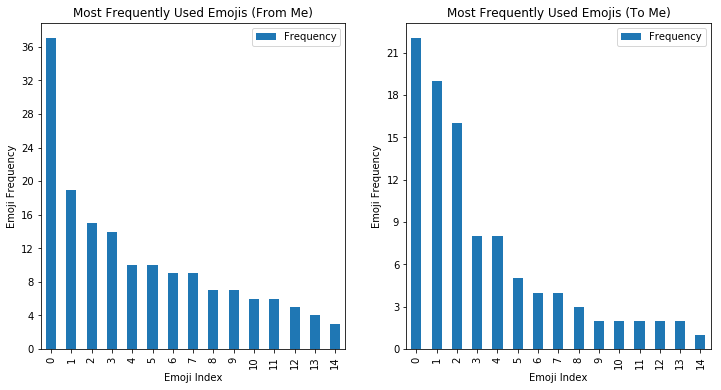

In [10]:
comparison_plot(emoji_plot, from_emojis, to_emojis)

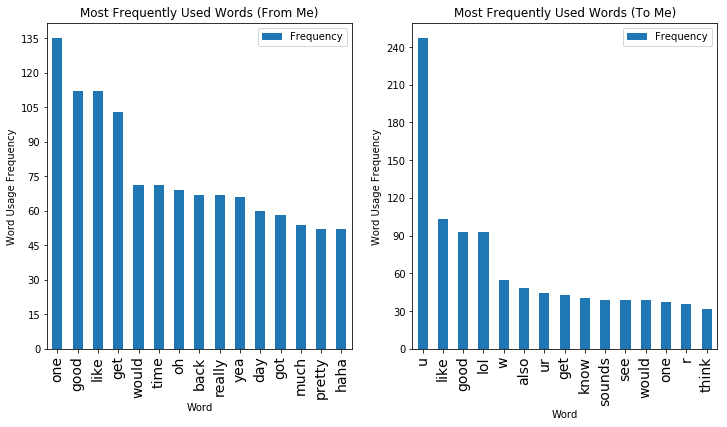

In [11]:
from_vocab = vocab_table(from_normalized).head(summary_count)
to_vocab = vocab_table(to_normalized).head(summary_count)

comparison_plot(vocab_plot, from_vocab, to_vocab)

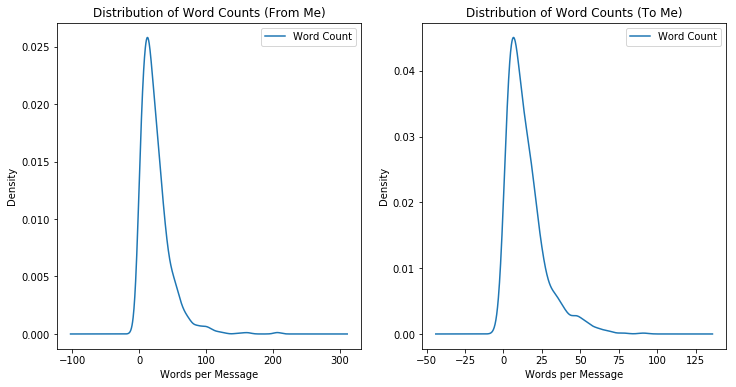

In [12]:
from_wordcounts = word_count_table(from_normalized)
to_wordcounts = word_count_table(to_normalized)

comparison_plot(word_count_plot, from_wordcounts, to_wordcounts)

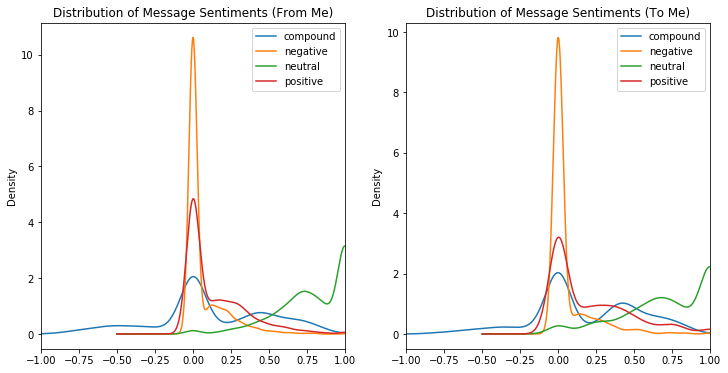

In [13]:
comparison_plot(sentiment_plot, from_sentiment, to_sentiment)

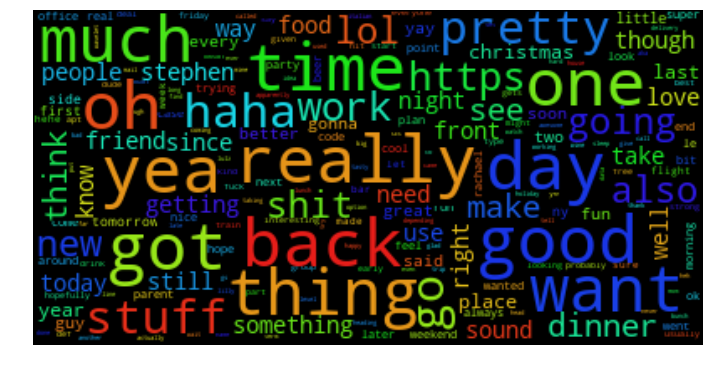

In [14]:
word_cloud(from_normalized)

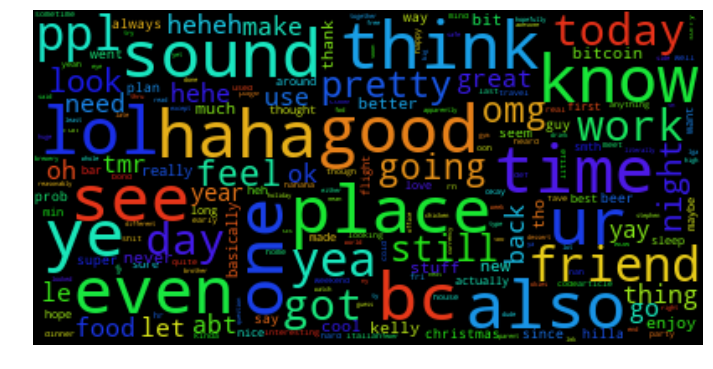

In [15]:
word_cloud(to_normalized)